In [269]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import sklearn.metrics
import numpy as np
import seaborn as sns
import sqlalchemy
import tensorflow as tf
import tensorflow.keras as keras

import energy.create_training_table as ctr
import energy.scaler
import energy.selects as selects
import energy.utils as utils

%reload_ext autoreload

engine = sqlalchemy.create_engine(selects.CONN_STR)


def md(msg):
    display(Markdown(msg))

import matplotlib.pyplot as plt

def show_correlation_graph(data, title=None, cmap=None, linewidths=0, figsize=(9, 6), annot=True):
    if cmap is None:
        cmap = sns.diverging_palette(10, 120, as_cmap=True)
    data = data.dropna()    
    corr = data.corr()
    for column_name in corr.columns:
        corr[column_name] = corr[column_name].abs()
    _, ax = plt.subplots(figsize=figsize)
    if title:
        ax.set_title(title)

    sns.heatmap(corr, annot=annot, fmt="2.2f", linewidths=linewidths, ax=ax, cmap=cmap)    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Take a look on the raw data


In [259]:
weather = pd.read_csv("../data/weather_features.csv")
energy = pd.read_csv("../data/energy_dataset.csv")

### Weather


In [261]:
weather.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,178396.0,289.618605,8.026199,262.24,283.670000,289.15,295.150000,315.600
temp_min,178396.0,288.330442,7.955491,262.24,282.483602,288.15,293.730125,315.150
temp_max,178396.0,291.091267,8.612454,262.24,284.650000,290.15,297.150000,321.150
pressure,178396.0,1069.260740,5969.631893,0.00,1013.000000,1018.00,1022.000000,1008371.000
humidity,178396.0,68.423457,21.902888,0.00,53.000000,72.00,87.000000,100.000
wind_speed,178396.0,2.470560,2.095910,0.00,1.000000,2.00,4.000000,133.000
wind_deg,178396.0,166.591190,116.611927,0.00,55.000000,177.00,270.000000,360.000
rain_1h,178396.0,0.075492,0.398847,0.00,0.000000,0.00,0.000000,12.000
rain_3h,178396.0,0.000380,0.007288,0.00,0.000000,0.00,0.000000,2.315
snow_3h,178396.0,0.004763,0.222604,0.00,0.000000,0.00,0.000000,21.500


### Energy

In [260]:
energy.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
generation biomass,35045.0,383.513540,85.353943,0.00,333.0000,367.00,433.00,592.00
generation fossil brown coal/lignite,35046.0,448.059208,354.568590,0.00,0.0000,509.00,757.00,999.00
generation fossil coal-derived gas,35046.0,0.000000,0.000000,0.00,0.0000,0.00,0.00,0.00
generation fossil gas,35046.0,5622.737488,2201.830478,0.00,4126.0000,4969.00,6429.00,20034.00
generation fossil hard coal,35046.0,4256.065742,1961.601013,0.00,2527.0000,4474.00,5838.75,8359.00
generation fossil oil,35045.0,298.319789,52.520673,0.00,263.0000,300.00,330.00,449.00
generation fossil oil shale,35046.0,0.000000,0.000000,0.00,0.0000,0.00,0.00,0.00
generation fossil peat,35046.0,0.000000,0.000000,0.00,0.0000,0.00,0.00,0.00
generation geothermal,35046.0,0.000000,0.000000,0.00,0.0000,0.00,0.00,0.00
generation hydro pumped storage aggregated,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


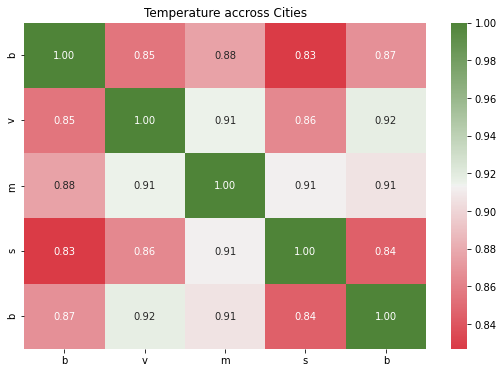

In [293]:
sql = "select bilbao as B, valencia as V, madrid as M, seville as S, barcelona as B from master; "
data = pd.read_sql_query( sql, con=engine)
show_correlation_graph(data, title="Temperature accross Cities", cmap=None, linewidths=0, figsize=(9, 6), annot=True)


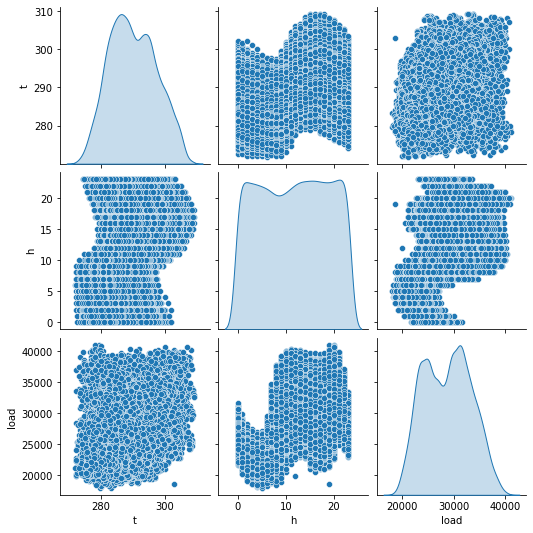

In [271]:
sql = "select average_temp as t, extract(hour from date_time) as h, load from master"
data = pd.read_sql_query( sql, con=engine)
sns.pairplot(data[['t', 'h', 'load']], diag_kind='kde')


In [10]:
engine = sqlalchemy.create_engine(selects.CONN_STR)
sql = "select date_time, temp from weather where city_name = 'Valencia' order by 1;"
data = pd.read_sql_query( sql, con=engine)

<AxesSubplot:>

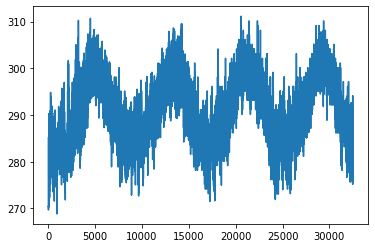

In [13]:
data.temp.plot()

<AxesSubplot:>

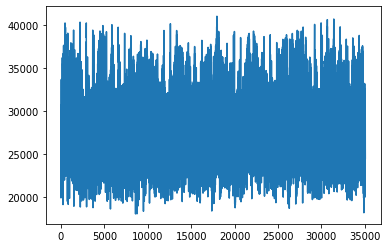

In [16]:
sql = "select date_time, total_load_actual from energy order by 1;"
data = pd.read_sql_query( sql, con=engine)
data.total_load_actual.plot()

In [78]:
def process(X, Y, title='no title', xlabel='x', ylabel='y', 
            show_least_square=False, scatter_color='gray', 
           least_square_color='blue'): 
    plt.scatter(X, Y,  color=scatter_color)
    if show_least_square:
        s = int(len(X) * 0.8)
        X_train = X[:s]
        Y_train = Y[:s]
        X_test = X[s:]
        Y_test = Y[s:]
        regr = linear_model.LinearRegression()
        regr.fit(X_train, Y_train)
        y_pred = regr.predict(X_test)
        plt.plot(X_test, y_pred, color=least_square_color, linewidth=3)
    plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
#     plt.xticks(())
#     plt.yticks(())
    plt.show()


No handles with labels found to put in legend.


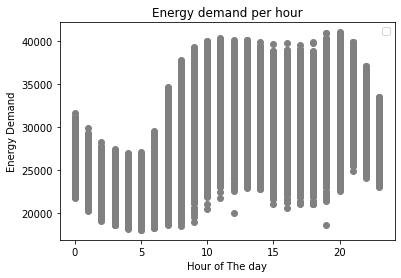

In [81]:
from sklearn import datasets, linear_model

sql = "select extract(hour from date_time) as hour, total_load_actual as load from energy where  total_load_actual  is not  NULL;"
data = pd.read_sql_query( sql, con=engine)
data = data.dropna()

title = 'Energy demand per hour'
xlabel = 'Hour of The day'
ylabel = 'Energy Demand'
    

process(data['hour'].to_frame(), data['load'].to_frame(), title=title, xlabel=xlabel, ylabel=ylabel)

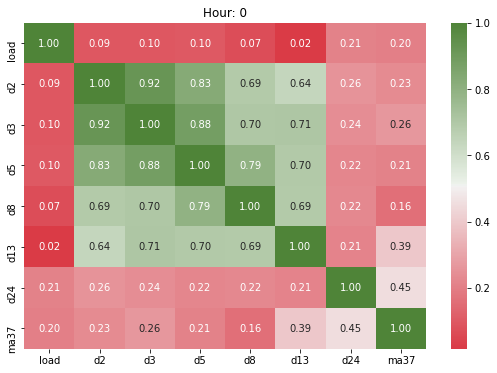

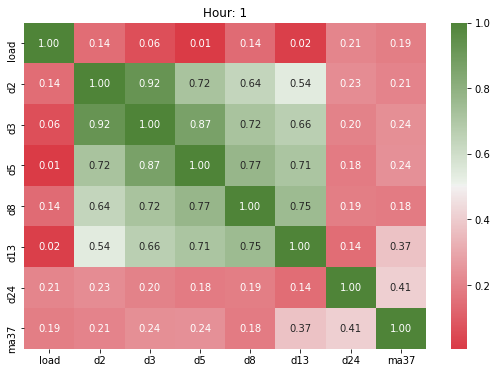

In [209]:
def load_diff_correlations_per_hour(hour_of_the_day):
    sql = f"select load, diff2 as d2, diff3 as d3, diff5 as d5, diff8  as d8, diff13 as d13, diff24 as d24, diff37 as ma37 from ensemble_data where hour = {hour_of_the_day};"
    data = pd.read_sql_query( sql, con=engine)
    show_correlation_graph(data, figsize=(9, 6), annot=True, title=f'Hour: {hour_of_the_day}')
    
def load_diff_correlations():
    for hour in range(0, 2):
        load_diff_correlations_per_hour(hour)

load_diff_correlations()


In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)
sns.heatmap(uniform_data, ax=ax1)
sns.heatmap(uniform_data2, ax=ax2)
plt.show()

No handles with labels found to put in legend.


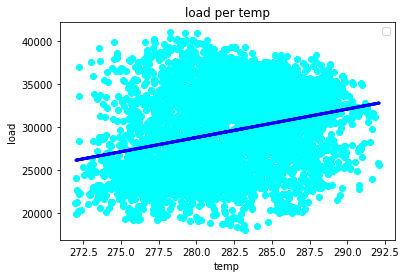

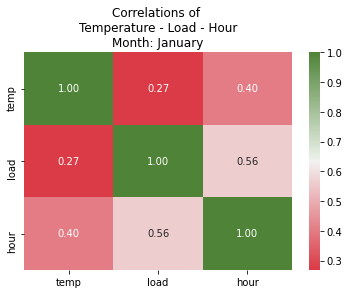

In [316]:
# Here we see what is the relationship between temperature
# and energy load.

sql = """
select average_temp as temp, load, extract(hour from a.date_time) as hour 
from master a, energy b 
where
a.date_time = b.date_time 
and extract(month from a.date_time) between 1 and 2;
"""

temp_load = pd.read_sql_query( sql, con=engine)

process(temp_load['temp'].to_frame(), 
        temp_load['load'].to_frame(), 
        title='load per temp', 
        xlabel='temp', 
        ylabel='load',
        show_least_square=True, 
        scatter_color='cyan', 
        least_square_color='blue')

show_correlation_graph(temp_load, figsize=(6, 4), title='Correlations of \nTemperature - Load - Hour\nMonth: January')



No handles with labels found to put in legend.


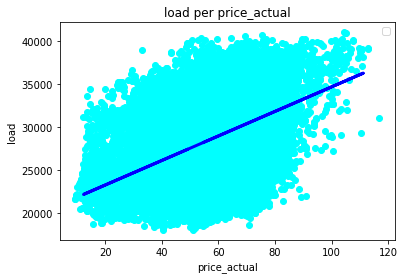

In [84]:
sql = "select load as l, price_actual as p from ensemble_data"

temp_load = pd.read_sql_query( sql, con=engine)

process(temp_load['p'].to_frame(), 
        temp_load['l'].to_frame(), 
        title='load per price_actual', 
        xlabel='price_actual', 
        ylabel='load',
        show_least_square=True, 
        scatter_color='cyan', 
        least_square_color='blue')



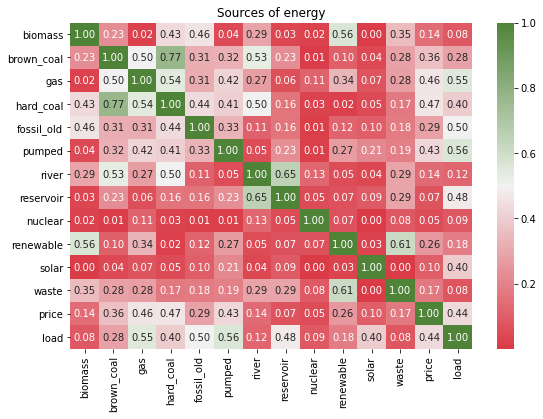

In [296]:
sql = """
SELECT 
    generation_biomass as biomass,
    generation_fossil_brown_coal_lignite as brown_coal,
    generation_fossil_gas as gas,
    generation_fossil_hard_coal as hard_coal,
    generation_fossil_oil as fossil_old,
    generation_hydro_pumped_storage_consumption as pumped,
    generation_hydro_run_of_river_and_poundage as river,
    generation_hydro_water_reservoir as reservoir,
    generation_nuclear as nuclear,
    generation_other_renewable as renewable,
    generation_solar as solar,
    generation_waste as waste,
    price_actual as price,
    total_load_actual as load
FROM 
    energy 
"""

gen_load = pd.read_sql_query( sql, con=engine)
show_correlation_graph(gen_load, figsize=(9, 6), annot=True,  title='Sources of energy')

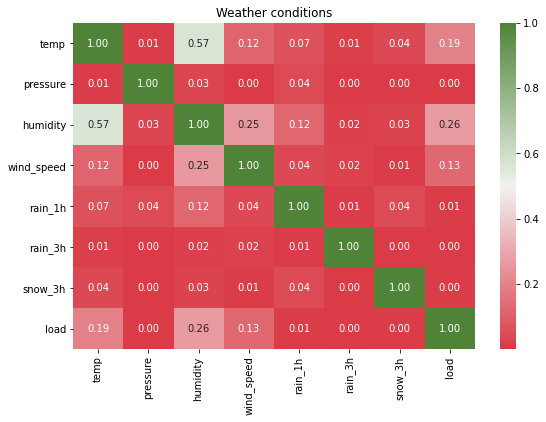

In [255]:
sql = """Select temp, pressure, humidity, wind_speed, rain_1h, rain_3h, snow_3h, total_load_actual as load from weather a, energy b where a.date_time = b.date_time;"""

gen_load = pd.read_sql_query( sql, con=engine)
show_correlation_graph(gen_load, figsize=(9, 6), annot=True,  title='Weather conditions')

In [251]:
import matplotlib.pyplot as plt

class HeatMap:
    def __init__(self, remove_diagonal_values=True):
        self._remove_diagonal_values = remove_diagonal_values
        self._data = []
        
    def add(self, df, title=None):
        df.title = title
        self._data.append(df)
        
    def remove_diagonal_values(self, data):
        if self._remove_diagonal_values:
            i = -1
            for _, row in data.iterrows():
                i += 1
                j = 0
                while j < i:
                    row[j] = 0
                    j += 1
        
    def show(self, rows, cols, cmap=None, linewidths=0, figsize=(6, 2), annot=True):
        if cmap is None:
            cmap = sns.diverging_palette(10, 120, as_cmap=True)
            
        fig, axs = plt.subplots(rows, cols, figsize=figsize)
        
        for row in range(rows):
            for col in range(cols):
                index = row * cols + col
                if index < len(self._data):
                    axs[row][col].set_title(self._data[index].title)
        
        for row in range(rows):
            for col in range(cols):
                index = row * cols + col
                if index >= len(self._data):
                    break
                sns.heatmap(
                    self._data[index], 
                    ax=axs[row][col], 
                    annot=annot, fmt="2.2f", 
                    linewidths=linewidths, 
                    cmap=cmap,
                    cbar=False
                )
        
        plt.show()


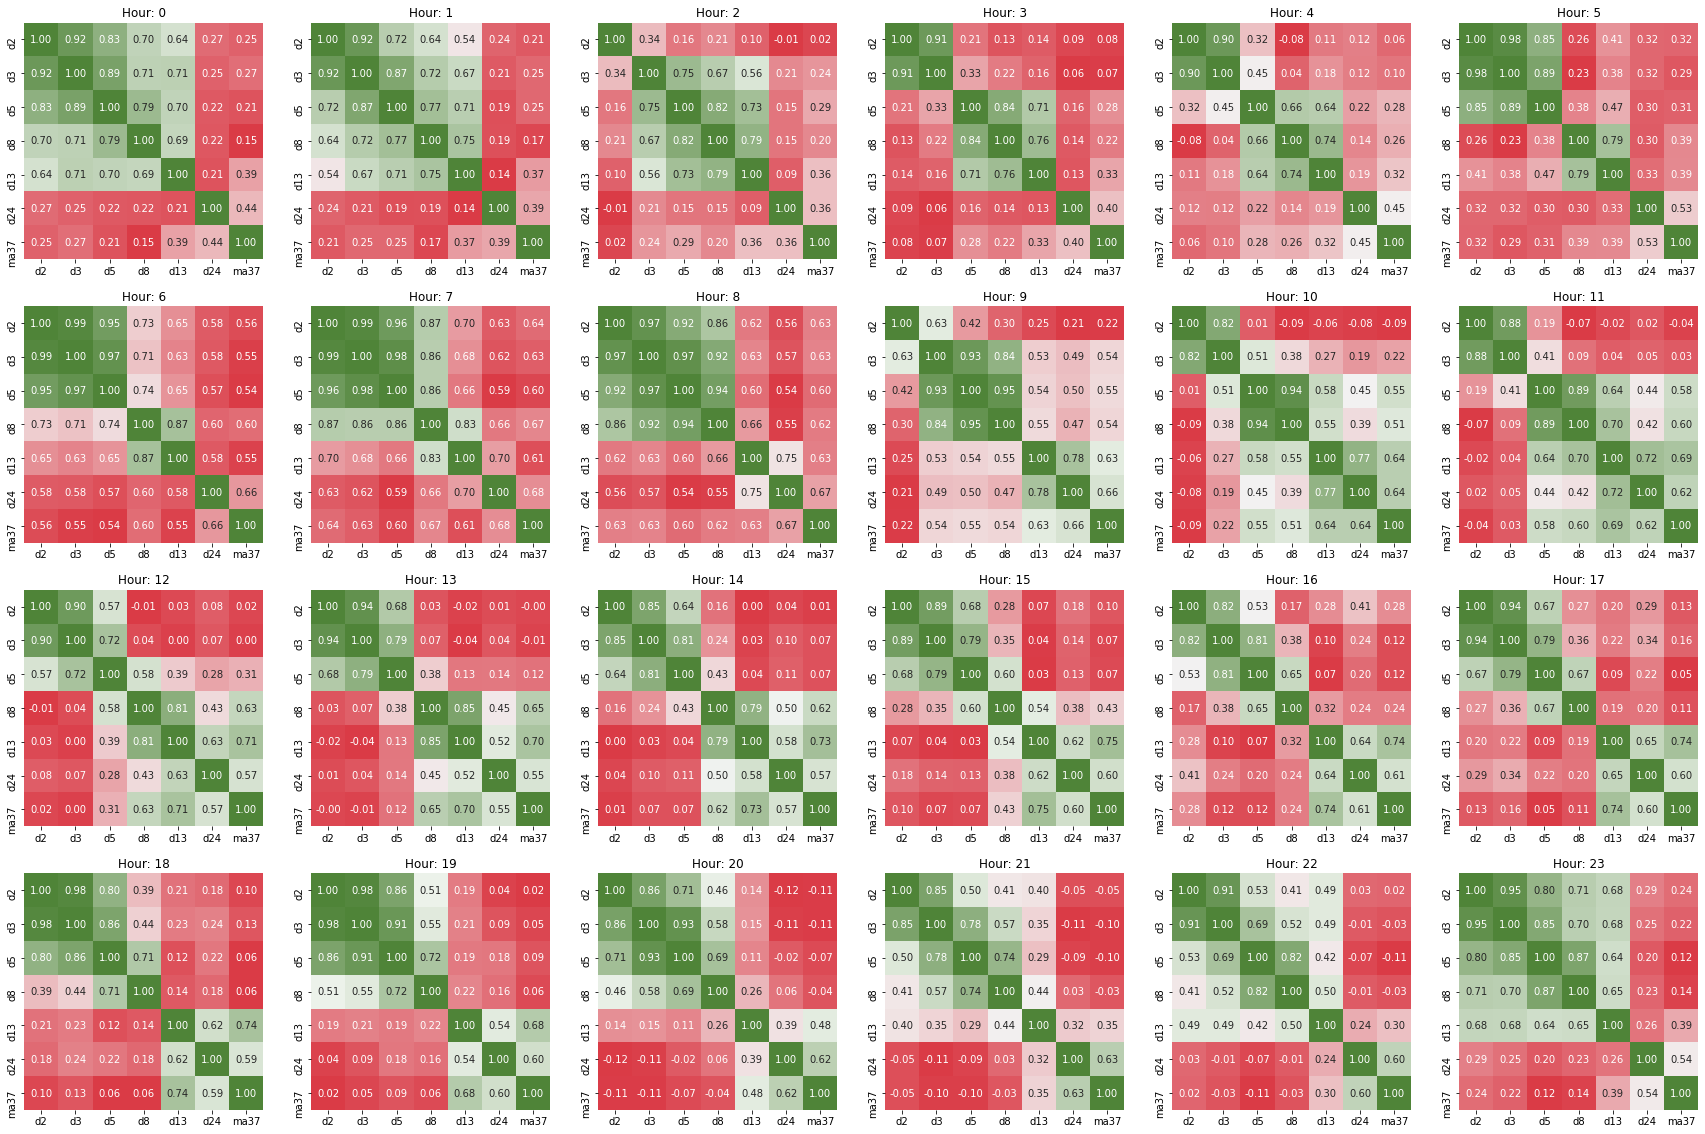

In [252]:
hm = HeatMap(remove_diagonal_values=True)

for hour in range(0, 24):                          
    sql = f"select diff2 as d2, diff3 as d3, diff5 as d5, diff8  as d8, diff13 as d13, diff24 as d24, diff37 as ma37 from ensemble_data where hour = {hour};"
    data = pd.read_sql_query( sql, con=engine)
    title=f'Hour: {hour}'
    hm.add(data.corr(), title)
    
#hm.show(rows=4, cols=6, annot=False, figsize=(30, 40))
hm.show(rows=4, cols=6, annot=True, figsize=(30, 20))


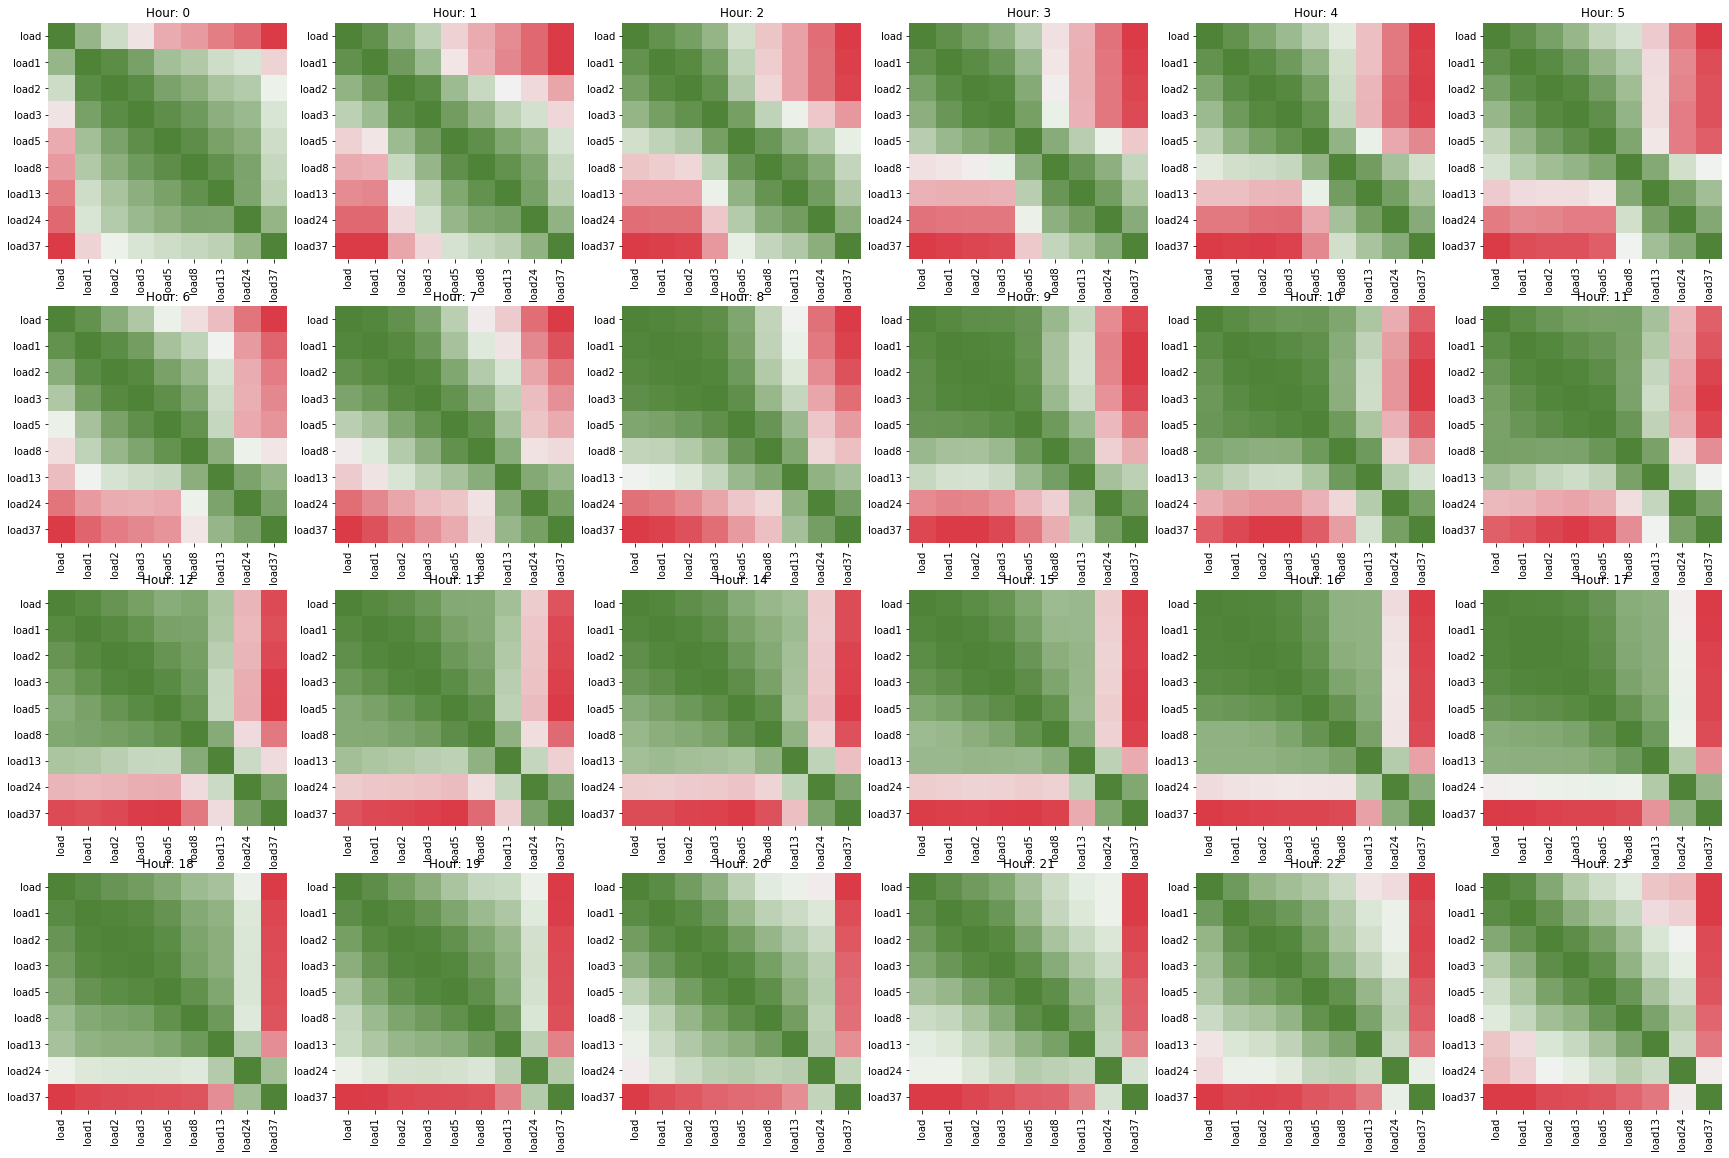

In [253]:
hm = HeatMap()

for hour in range(0, 24):                          
    sql = f"select load, load1, load2, load3, load5, load8, load13, load24, load37 from ensemble_data where hour = {hour};"
    data = pd.read_sql_query( sql, con=engine)
    title=f'Hour: {hour}'
    hm.add(data.corr(), title)
    
#hm.show(rows=4, cols=6, annot=False, figsize=(30, 40))
hm.show(rows=4, cols=6, annot=False, figsize=(30, 20))


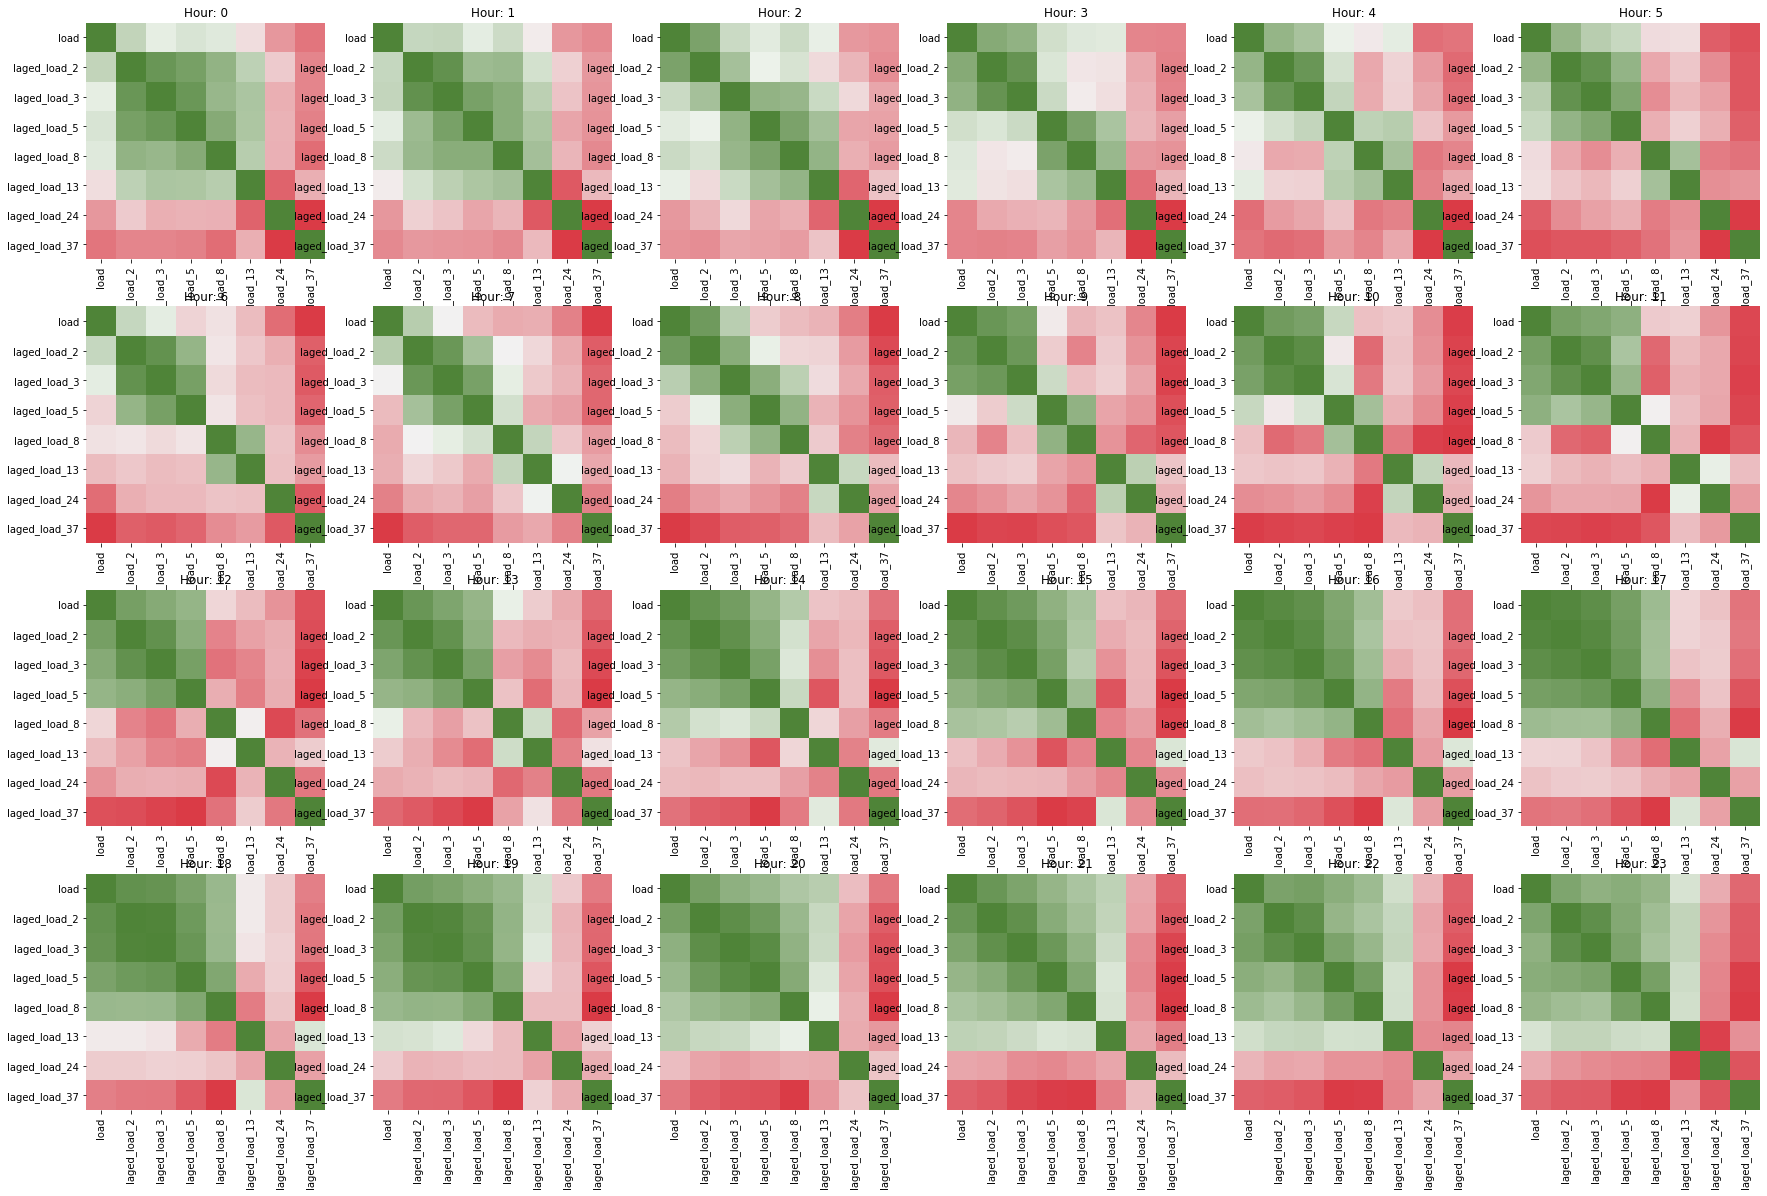

In [254]:


hm = HeatMap()

for hour in range(0, 24):                          
    sql = f"select load, laged_load_2, laged_load_3, laged_load_5, laged_load_8, laged_load_13, laged_load_24, laged_load_37 from ensemble_data where hour = {hour};"
    data = pd.read_sql_query( sql, con=engine)
    title=f'Hour: {hour}'
    hm.add(data.corr(), title)
    
#hm.show(rows=4, cols=6, annot=False, figsize=(30, 40))
hm.show(rows=4, cols=6, annot=False, figsize=(30, 20))


<AxesSubplot:>

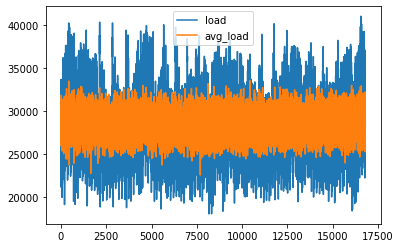

In [294]:
sql = "select load, (avg(load)  over (rows between 10 preceding and current row)) as avg_load from ensemble_data where date_time between ' 2015-01-02 13:00:00' and  '2017-01-31 13:00:00' order by date_time;"
data = pd.read_sql_query( sql, con=engine)
data.plot()

<AxesSubplot:>

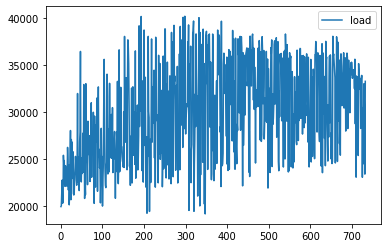

In [324]:
sql = """
select load
from master a, energy b 
where
a.date_time = b.date_time 
and extract(month from a.date_time) = 1
and extract(year from a.date_time) = 2015
order by average_temp;
"""
data = pd.read_sql_query( sql, con=engine)
data.plot()

In [313]:
data.corr()

,temp,load
temp,1.000000,0.268752
load,0.268752,1.000000


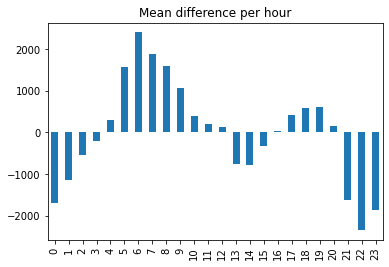

In [325]:
sql = """select hour, median_diff_per_hour from diff_per_hour order by 1;"""

median_diff = pd.read_sql_query(sql, con=engine)
_ = median_diff['median_diff_per_hour'].plot(kind='bar', title='Mean difference per hour')

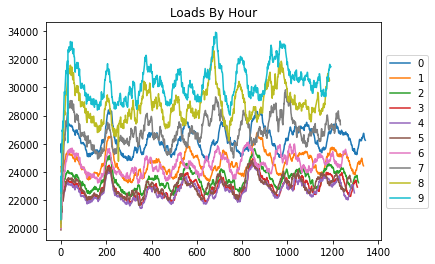

In [326]:
def plot_load_by_hour(hour):
    sql = f"select date_time, load, (avg(load)  over (rows between 30 preceding and current row)) as ma from master where extract(hour from date_time) = {hour} order by 1"
    load_by_hour = pd.read_sql_query(sql, con=engine)
    load_by_hour['ma'].plot(title='Loads By Hour')
    
for hour in range(0, 10):
    plot_load_by_hour(hour)

labels = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23']

_ = plt.legend(labels,loc='center left', bbox_to_anchor=(1.0, 0.5))

    

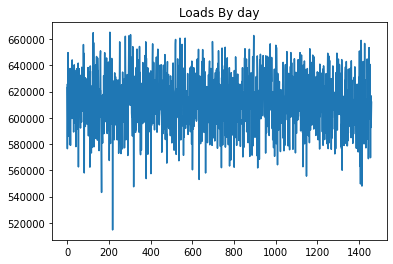

In [327]:
sql = """select (avg(load)  over (rows between 30 preceding and current row)) as load from daily_data order by date_time"""
load_by_day = pd.read_sql_query(sql, con=engine)
_ = load_by_day['load'].plot(title='Loads By day')

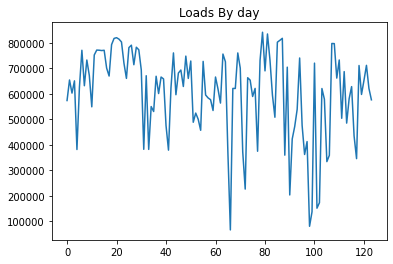

In [328]:
sql = """select load from daily_data where extract(month from date_time) = 1 order by date_time"""
load_by_day = pd.read_sql_query(sql, con=engine)
_ = load_by_day['load'].plot(title='Loads By day')

In [329]:
median_diff

junk = pd.DataFrame()
junk['success_rate'] = df['success_rate'] - 0.81
junk['median_diff_per_hour'] = median_diff['median_diff_per_hour'].abs()

junk

print(junk.corr())

_ = sns.pairplot(data=junk, y_vars=['success_rate'], x_vars=['median_diff_per_hour'])


NameError: name 'df' is not defined